[View in Colaboratory](https://colab.research.google.com/github/keicoon/Deep-Learning/blob/master/GAN/DCGAN.ipynb)

In [1]:
# dependency modules
!pip install tqdm scipy requests imageio scikit-image

In [0]:
# celebA 데이터 셋을 MNIST 데이터 셋과 같이 사용할 수 있도록 함
# http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# reference : https://github.com/carpedm20/DCGAN-tensorflow/blob/master/download.py

from glob import glob
import scipy.misc
import imageio
import skimage.transform
# util functions
def center_crop(x, crop_h, crop_w,
                resize_h=64, resize_w=64):
  if crop_w is None:
    crop_w = crop_h
  h, w = x.shape[:2]
  j = int(round((h - crop_h)/2.))
  i = int(round((w - crop_w)/2.))
  return skimage.transform.resize(x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w], mode='constant')

def transform(image, input_height, input_width, 
              resize_height=64, resize_width=64, crop=True):
  cropped_image = center_crop(image, input_height, input_width, resize_height, resize_width)
  images = cropped_image.astype(np.float32)
  images = np.subtract(np.multiply(images, 1.0 / 127.5), 1.0)
  return images

def imread(path):
  image = imageio.imread(path).astype(np.float)
  return transform(image, input_height=108, input_width=108, resize_height=64, resize_width=64, crop=True).astype(np.float32)

def save_response_content(response, destination, chunk_size=32*1024):
  total_size = int(response.headers.get('content-length', 0))
  with open(destination, "wb") as f:
    for chunk in tqdm(response.iter_content(chunk_size), total=total_size,
              unit='B', unit_scale=True, desc=destination):
      if chunk: # filter out keep-alive new chunks
        f.write(chunk)
        
def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value
  return None

def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"
  session = requests.Session()

  response = session.get(URL, params={ 'id': id }, stream=True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params=params, stream=True)

  save_response_content(response, destination)
#
def maybe_download(dirpath):
    if not os.path.exists(dirpath):
      os.mkdir(dirpath)
    data_dir = 'celebA'
    if os.path.exists(os.path.join(dirpath, data_dir)):
      print('Found Celeb-A - skip')
      return os.path.join(dirpath, "celebA", "*.jpg")

    filename, drive_id  = "img_align_celeba.zip", "0B7EVK8r0v71pZjFTYXZWM3FlRnM"
    save_path = os.path.join(dirpath, filename)

    if os.path.exists(save_path):
      print('[*] {} already exists'.format(save_path))
    else:
      download_file_from_google_drive(drive_id, save_path)

    zip_dir = ''
    with zipfile.ZipFile(save_path) as zf:
      zip_dir = zf.namelist()[0]
      zf.extractall(dirpath)
    os.remove(save_path)
    os.rename(os.path.join(dirpath, zip_dir), os.path.join(dirpath, data_dir))
    
    return os.path.join(dirpath, "celebA", "*.jpg")
# reference: https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/contrib/learn/python/learn/datasets/mnist.py
class DataSet(object):
  def __init__(self, images):
    self._num_examples = images.shape[0]
    self._images = images
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
      return self._images

  @property
  def num_examples(self):
      return self._num_examples

  @property
  def epochs_completed(self):
      return self._epochs_completed
  
  def next_batch(self, batch_size, shuffle=True):
    start = self._index_in_epoch
    if self._epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(self._num_examples)
      np.random.shuffle(perm0)
      self._images = self.images[perm0]
    # Go to the next epoch
    if start + batch_size > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = self._num_examples - start
      images_rest_part = self._images[start:self._num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(self._num_examples)
        np.random.shuffle(perm)
        self._images = self.images[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size - rest_num_examples
      end = self._index_in_epoch
      images_new_part = self._images[start:end]
      return np.concatenate((images_rest_part, images_new_part), axis=0)
    else:
      self._index_in_epoch += batch_size
      end = self._index_in_epoch
      return self._images[start:end]

  def read_data_sets(train_dir):
    class DataSets(object):
        pass  
    data_sets = DataSets()
    
    local_file = maybe_download(train_dir)
    local_data = glob(local_file)
    
    if len(local_data) == 0:
      raise Exception("[!] No data found in '" + data_path + "'")
    
    train_images = np.asarray([imread(data) for data in local_data[:3000]])
    
    data_sets.train = DataSet(train_images) # not ready to use label data.
    
    return data_sets

In [3]:
import os
import zipfile
import requests

import numpy as np
import tensorflow as tf

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

celebA = DataSet.read_data_sets("data/")
print('celebA.train.num_examples : ', celebA.train.num_examples)

Found Celeb-A - skip
celebA.train.num_examples :  3000


In [0]:
def generator(X, isTrain=True):
  with tf.variable_scope('generator', reuse=False):
    X = tf.reshape(X, shape=(-1, 1, 1, 100))
    
    dc1 = tf.contrib.layers.conv2d_transpose(X, 1024, 4, 1, padding='VALID')
    dc1 = tf.nn.relu(tf.layers.batch_normalization(dc1, training=isTrain))
    
    dc2 = tf.contrib.layers.conv2d_transpose(dc1, 512, 4, 2, padding='SAME')
    dc2 = tf.nn.relu(tf.layers.batch_normalization(dc2, training=isTrain))
    
    dc3 = tf.contrib.layers.conv2d_transpose(dc2, 256, 4, 2, padding='SAME')
    dc3 = tf.nn.relu(tf.layers.batch_normalization(dc3, training=isTrain))

    dc4 = tf.contrib.layers.conv2d_transpose(dc3, 128, 4, 2, padding='SAME')
    dc4 = tf.nn.relu(tf.layers.batch_normalization(dc4, training=isTrain))
    
    G = tf.contrib.layers.conv2d_transpose(dc4, 3, 4, 2, padding='SAME', activation_fn=tf.nn.tanh)
    
    return G
  
def discriminator(X, isTrain=True, reuse=False):
  with tf.variable_scope('discriminator', reuse=reuse):
    c1 = tf.contrib.layers.conv2d(X, 128, 4, 2, padding='SAME', activation_fn=tf.nn.leaky_relu)

    c2 = tf.contrib.layers.conv2d(c1, 256, 4, 2, padding='SAME')
    c2 = tf.nn.leaky_relu(tf.layers.batch_normalization(c2, training=isTrain))
    
    c3 = tf.contrib.layers.conv2d(c2, 512, 4, 2, padding='SAME')
    c3 = tf.nn.leaky_relu(tf.layers.batch_normalization(c3, training=isTrain))
    
    c4 = tf.contrib.layers.conv2d(c3, 1024, 4, 2, padding='SAME')
    c4 = tf.nn.leaky_relu(tf.layers.batch_normalization(c4, training=isTrain))
    
    D = tf.contrib.layers.conv2d(c4, 1, 4, 1, 'VALID', activation_fn=tf.nn.sigmoid)
    
  return D

def GAN(X, Z, isTrain):
  G = generator(Z, isTrain)
  
  real = discriminator(X, isTrain)
  gene = discriminator(G, isTrain, reuse=True)

  return G, Z, real, gene
  
def loss(real, gene):
  loss_D = tf.reduce_mean(tf.log(real) + tf.log(1 - gene))
  loss_G = tf.reduce_mean(tf.log(gene))
  
  return -loss_D, -loss_G

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

tf.reset_default_graph()

batch_size = 16
n_samples = int(celebA.train.num_examples)
total_batch = int(n_samples / batch_size)

X = tf.placeholder(tf.float32, [None, 64, 64, 3])
Z = tf.placeholder(tf.float32, [None, 100])
isTrain = tf.placeholder(dtype=tf.bool)

G, Z, real, gene = GAN(X, Z, isTrain)
loss_D, loss_G = loss(real, gene)

disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
gene_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')

global_step = tf.Variable(0, name='global_step', trainable=False)

train_op_D = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_D, var_list=disc_vars, global_step=global_step)
train_op_G = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(loss_G, var_list=gene_vars)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [0]:
def test():
    n = 4
    
    canvas_recon = np.empty((64 * n, 64 * n, 3))
    for i in range(n):
        noise = np.random.normal(size=(n, 100))
        
        recon = sess.run(G, feed_dict={Z: noise, isTrain: False})

        # Display reconstructed images
        for j in range(n):
            # Draw the generated digits
            recon[j] = np.multiply(np.add(recon[j], 1.0), 0.5)
            canvas_recon[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = recon[j].reshape([64, 64, 3])

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon)
    plt.show()

g_step:0 step: 1 loss_d: 0.582 loss_g: 14.431
g_step:23 step: 2 loss_d: 0.106 loss_g: 16.746
g_step:46 step: 3 loss_d: 0.066 loss_g: 20.547
g_step:69 step: 4 loss_d: 0.037 loss_g: 13.805
g_step:92 step: 5 loss_d: 0.076 loss_g: 19.431
g_step:115 step: 6 loss_d: 0.075 loss_g: 16.802
g_step:138 step: 7 loss_d: 0.184 loss_g: 22.938
g_step:161 step: 8 loss_d: 0.324 loss_g: 15.807
g_step:184 step: 9 loss_d: 0.298 loss_g: 11.426
g_step:207 step: 10 loss_d: 0.224 loss_g: 9.487
g_step:230 step: 11 loss_d: 0.147 loss_g: 9.057
Reconstructed Images


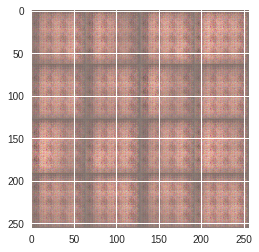

g_step:253 step: 12 loss_d: 0.250 loss_g: 8.215
g_step:276 step: 13 loss_d: 0.583 loss_g: 7.869
g_step:299 step: 14 loss_d: 0.645 loss_g: 7.120
g_step:322 step: 15 loss_d: 0.636 loss_g: 7.857
g_step:345 step: 16 loss_d: 0.475 loss_g: 7.374
g_step:368 step: 17 loss_d: 0.415 loss_g: 7.187
g_step:391 step: 18 loss_d: 0.513 loss_g: 8.675
g_step:414 step: 19 loss_d: 0.571 loss_g: 6.193
g_step:437 step: 20 loss_d: 0.428 loss_g: 6.504
g_step:460 step: 21 loss_d: 0.398 loss_g: 6.876
Reconstructed Images


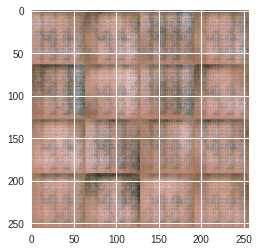

g_step:483 step: 22 loss_d: 0.388 loss_g: 6.077
g_step:506 step: 23 loss_d: 0.461 loss_g: 5.272
g_step:529 step: 24 loss_d: 0.419 loss_g: 5.869
g_step:552 step: 25 loss_d: 0.360 loss_g: 6.508
g_step:575 step: 26 loss_d: 0.730 loss_g: 5.438
g_step:598 step: 27 loss_d: 0.552 loss_g: 5.681
g_step:621 step: 28 loss_d: 0.422 loss_g: 5.292
g_step:644 step: 29 loss_d: 0.504 loss_g: 4.967
g_step:667 step: 30 loss_d: 0.376 loss_g: 5.927
g_step:690 step: 31 loss_d: 0.297 loss_g: 6.306
Reconstructed Images


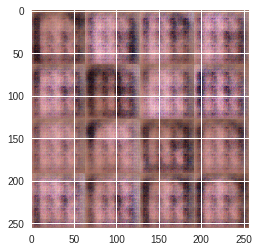

g_step:713 step: 32 loss_d: 0.242 loss_g: 5.907
g_step:736 step: 33 loss_d: 0.365 loss_g: 5.313
g_step:759 step: 34 loss_d: 0.412 loss_g: 6.107
g_step:782 step: 35 loss_d: 0.305 loss_g: 6.374
g_step:805 step: 36 loss_d: 0.278 loss_g: 5.996
g_step:828 step: 37 loss_d: 0.422 loss_g: 5.636
g_step:851 step: 38 loss_d: 0.391 loss_g: 5.048
g_step:874 step: 39 loss_d: 0.388 loss_g: 5.590
g_step:897 step: 40 loss_d: 0.283 loss_g: 6.360
g_step:920 step: 41 loss_d: 0.323 loss_g: 6.586
Reconstructed Images


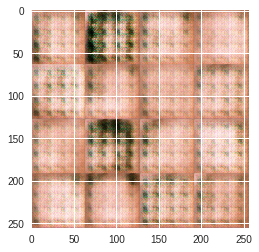

g_step:943 step: 42 loss_d: 0.205 loss_g: 5.856
g_step:966 step: 43 loss_d: 0.333 loss_g: 5.487
g_step:989 step: 44 loss_d: 0.340 loss_g: 5.864
g_step:1012 step: 45 loss_d: 0.299 loss_g: 5.754
g_step:1035 step: 46 loss_d: 0.348 loss_g: 5.387
g_step:1058 step: 47 loss_d: 0.395 loss_g: 5.324
g_step:1081 step: 48 loss_d: 0.341 loss_g: 5.944
g_step:1104 step: 49 loss_d: 0.349 loss_g: 6.470
g_step:1127 step: 50 loss_d: 0.406 loss_g: 5.772
g_step:1150 step: 51 loss_d: 0.291 loss_g: 5.653
Reconstructed Images


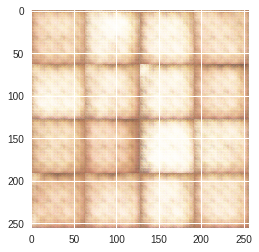

In [0]:
def train():
  training_epochs = 101
  
  for epoch in range(training_epochs):
    global_step_num = sess.run(global_step)
    
    sum_loss_d = 0.
    sum_loss_g = 0.
    
    for i in range(total_batch):
      batch_x = celebA.train.next_batch(batch_size, shuffle=True)
      
      noise = np.random.normal(size=(batch_size, 100))
      
      _, loss_d = sess.run([train_op_D, loss_D], feed_dict={X: batch_x, Z: noise, isTrain: True})
      _, loss_g_1 = sess.run([train_op_G, loss_G], feed_dict={Z: noise, isTrain: True})
      _, loss_g_2 = sess.run([train_op_G, loss_G], feed_dict={Z: noise, isTrain: True})
      
      sum_loss_d += loss_d
      sum_loss_g += (loss_g_1 + loss_g_2) * 0.5
    # test
    print('g_step:{} step: {} loss_d: {:>3.3f} loss_g: {:>3.3f}'.format(global_step_num, epoch + 1, sum_loss_d/total_batch, sum_loss_g/total_batch))
    if epoch % 10 == 0 and epoch > 0:
      test()
train()